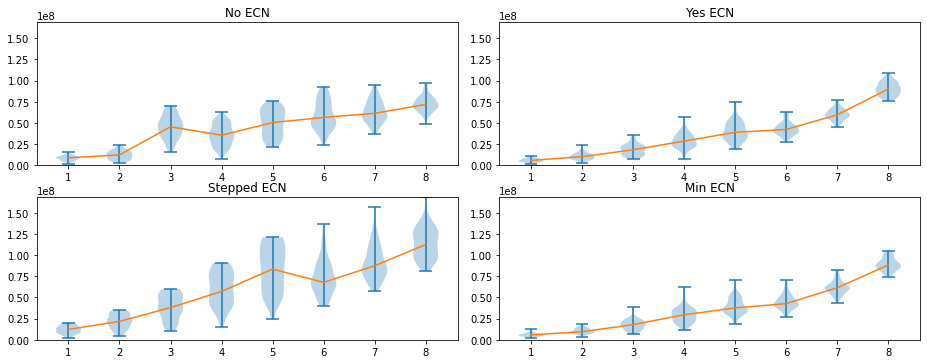

In [19]:
import matplotlib.pyplot as plt
from os import listdir
import json
from os.path import isfile, join
import numpy as np
from typing import Callable, Union, Tuple
from collections import defaultdict

plt.rcParams['figure.figsize'] = [13, 5]

ParamTuple = Tuple[int,int,int,int]

directories = [join("afd_test_results_json", subdir) for subdir in
                   ["no_ecn/decay_sweep", 
                   "no_ecn/threshold_growth",
                   "yes_ecn/decay_sweep",
                   "yes_ecn/threshold_growth",
                   "yes_ecn/delta_growth" ]
              ]


def flatten_decay(time_delta: int, scale: int):
    # Turn LPF parameters into a single integer
    return time_delta >> scale


def filename_to_param_tuple(filename: str) -> ParamTuple:
    # name format = thresh_%d_delta_%d_decay_%d_scale_%d.json
    name_pieces = filename.rstrip(".json").split("_")
    threshold = int(name_pieces[1])
    delta = float(name_pieces[3])
    decay = int(float(name_pieces[5]))  # param is written in scientific notation but is actually an int
    scale = int(name_pieces[7])
    
    # convert relative deltas to absolute
    if delta < 1:
        delta = int(delta * threshold)
    else:
        delta = int(delta)
        
    return (threshold, delta, decay, scale)


def process_directory(directory: str):
    filenames = [f for f in listdir(directory) if isfile(join(directory, f))]

    directory_avg_variance_coeffs = []
    for filename in filenames:
        print("Processing", filename)
        param_tuple = filename_to_param_tuple(filename)

        data = json.load(open(join(directory, filename), "r"))
        
        intervals = list(data["intervals"])[1:]  # discard first interval to allow for convergence
        interval_variance_coeffs = []
        for interval in intervals:
            flow_rates = [stream["bits_per_second"] for stream in interval["streams"]]
            variance_coefficient = np.std(flow_rates) / np.mean(flow_rates)
            interval_variance_coeffs.append(variance_coefficient)
        directory_avg_variance_coeffs.append((param_tuple, np.mean(interval_variance_coeffs)))
    return directory_avg_variance_coeffs


def plot_directory(directory: str, 
                   param_tuple_to_x_coord: Callable[ParamTuple, Union[int, float]],
                   title: str,
                   x_axis_label: str):
    data = process_directory(directory)
    points = [(param_tuple_to_x_coord(point[0]), point[1]) for point in data]
    points.sort(key = lambda x: x[0])
    x_points = [point[0] for point in points]
    y_points = [point[1] for point in points]
    fig,ax = plt.subplots()
    ax.set_title(title)
    ax.set_ylabel("Average Per-Interval Variance Coefficient")
    ax.set_xlabel(x_axis_label)
    line, = ax.plot(x_points, y_points, label="Label", linewidth=1.0)
    
    
def plot_decay_sweep_dir(directory: str,
                         title: str):
    data = process_directory(directory)
    decay_constant_to_points = defaultdict(list)
    decays = []
    scales = []
    variances = []
    for point in data:
        decay_constant, scale = point[0][2], point[0][3]
        variance =  point[1]
        
        decays.append(decay_constant)
        scales.append(scale)
        variances.append(variance)
        
    print(decays)
    print(scales)
    print(variances)
        
    fig,ax = plt.subplots()
    ax.set_title(title)
    ax.set_ylabel("LPF Scale")
    ax.set_xlabel("Decay Constant")
    scatter = ax.scatter(decays, scales, c=variances, linewidth=1.0)
    
def get_throughputs_for_directory(directory: str):
    """
    Return type: List of tuples of [((Decay, Scale), Stream_Bitrates)]
    """
    filenames = [f for f in listdir(directory) if isfile(join(directory, f))]
    
    decay_params_to_intervals = []

    for filename in filenames:
        #print("Processing", filename)
        param_tuple = filename_to_param_tuple(filename)

        data = json.load(open(join(directory, filename), "r"))
        
        all_bitrates = []
        intervals = list(data["intervals"])[1:]  # discard first interval to allow for convergence
        # just get the bitrates from each interval
        for interval in intervals:
            all_bitrates.extend([stream["bits_per_second"] for stream in interval["streams"]])
        
        decay_params_to_intervals.append(((param_tuple[2], param_tuple[3]), all_bitrates))
        decay_params_to_intervals.sort(key = lambda x: x[0][0])
                                         
    return decay_params_to_intervals

def max_throughput_in_dataset(dataset):
    return max(max(data[1]) for data in dataset)
    
    
def plot_throughput_vs_decay():
    data_names = ["No ECN", "Yes ECN", "Stepped ECN", "Min ECN"]
    
    data_dirs = ["afd_test_results_json/no_ecn/throughput_vs_decay/",
                 "afd_test_results_json/yes_ecn/throughput_vs_decay/",
                 "afd_test_results_json/stepped_ecn_0_06/throughput_vs_decay/",
                 "afd_test_results_json/min_ecn/throughput_vs_decay/"]
    
    data_sets = [get_throughputs_for_directory(data_dir) for data_dir in data_dirs]
    
    indices = [(0,0), (0,1), (1,0), (1,1)]
    
    y_max = max(max_throughput_in_dataset(data_set) for data_set in data_sets)
    
    assert(len(data_names) == len(data_dirs) == len(data_sets))
    
    
    fig, axes  = plt.subplots(2, 2)
    fig.tight_layout()
    
    for i, (data_name, data_dir, data_set, index) in enumerate(zip(data_names, data_dirs, data_sets, indices)):
        axes[index].set_title(data_name)
        vp = axes[index].violinplot([data[1] for data in data_set])
        axes[index].plot(range(1, len(data_set)+1), [np.median(data[1]) for data in data_set])
        axes[index].set_ylim([0, y_max])
        
    
    """
    
    axes[0].set_title("No ECN")
    vp = axes[0].violinplot([data[1] for data in data_no_ecn])
    axes[0].plot(range(1, len(data_no_ecn)+1), [np.median(data[1]) for data in data_no_ecn])
    
    axes[1].set_title("Yes ECN")
    vp = axes[1].violinplot([data[1] for data in data_yes_ecn])
    axes[1].plot(range(1, len(data_yes_ecn)+1), [np.median(data[1]) for data in data_yes_ecn])
    
    axes[2].set_title("Stepped ECN")
    vp = axes[2].violinplot([data[1] for data in data_stepped_ecn])
    axes[2].plot(range(1, len(data_stepped_ecn)+1), [np.median(data[1]) for data in data_stepped_ecn]) 
    
    """
                        
    
plot_throughput_vs_decay()
    
    
    
    
    

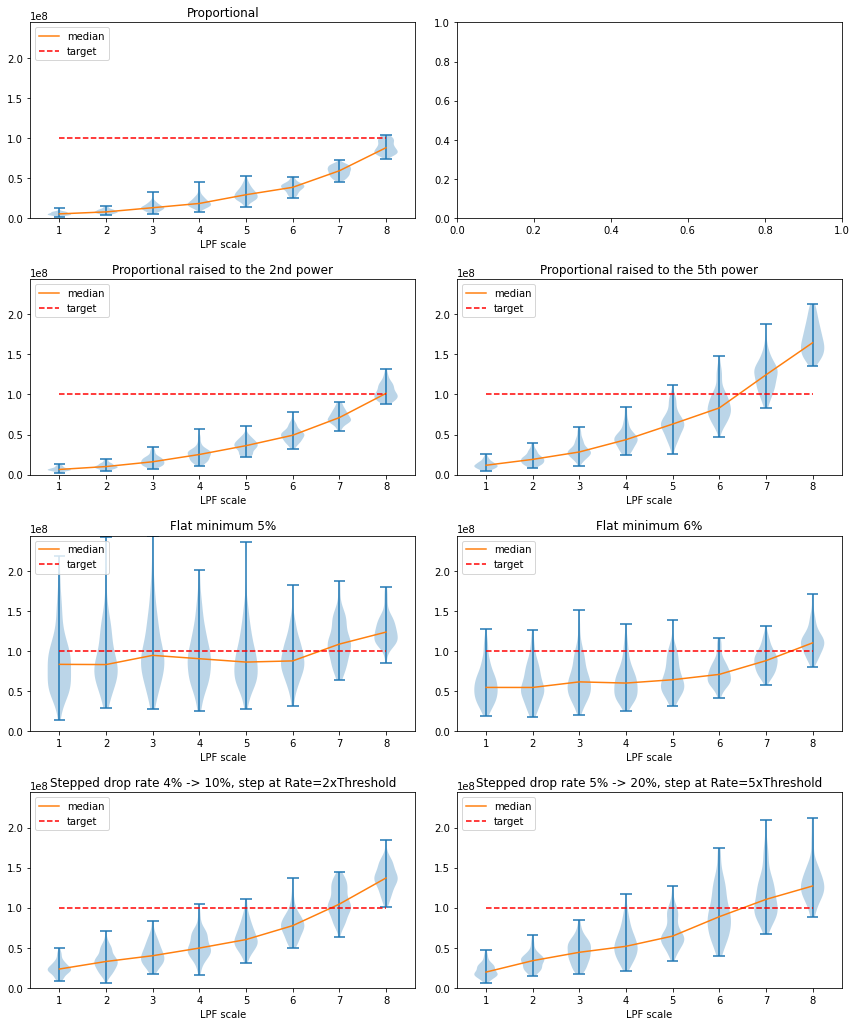

In [47]:
def plot_throughput_vs_decay_drop_curves():
    data_names = ["Proportional",
                  "Proportional raised to the 2nd power",
                  "Proportional raised to the 5th power", 
                  "Flat minimum 5%", 
                  "Flat minimum 6%",
                  "Stepped drop rate 4% -> 10%, step at Rate=2xThreshold",
                  "Stepped drop rate 5% -> 20%, step at Rate=5xThreshold"]
    
    data_dirs = ["afd_test_results_json/drop_curves/proportional/",
                 "afd_test_results_json/drop_curves/pow_2/",
                 "afd_test_results_json/drop_curves/pow_5/",
                 "afd_test_results_json/drop_curves/flat_5/",
                 "afd_test_results_json/drop_curves/flat_6/",
                 "afd_test_results_json/drop_curves/stepped/",
                 "afd_test_results_json/drop_curves/stepped_5_20_step8/"]
    
    data_sets = [get_throughputs_for_directory(data_dir) for data_dir in data_dirs]
    
    indices = [(0,0), (1,0), (1,1), (2,0), (2,1), (3,0), (3,1)]
    
    y_max = max(max_throughput_in_dataset(data_set) for data_set in data_sets)
    
    assert(len(data_names) == len(data_dirs) == len(data_sets))
    
    
    plt.rcParams['figure.figsize'] = [12,14]
    fig, axes  = plt.subplots(4, 2)
    fig.tight_layout(h_pad=4)
    
    for i, (data_name, data_dir, data_set, index) in enumerate(zip(data_names, data_dirs, data_sets, indices)):
        axes[index].set_title(data_name)
        vp = axes[index].violinplot([data[1] for data in data_set])
        axes[index].plot(range(1, len(data_set)+1), [np.median(data[1]) for data in data_set], 
                         label="median")
        axes[index].plot(range(1, len(data_set)+1), [1e8 for data in data_set], 
                         linestyle='dashed', color='red', label="target")
        axes[index].set_ylim([0, y_max])
        axes[index].set_xlabel("LPF scale")
        #axes[index].set_ylabel("BW")
        axes[index].legend(loc="upper left")
        
    
    """
    
    axes[0].set_title("No ECN")
    vp = axes[0].violinplot([data[1] for data in data_no_ecn])
    axes[0].plot(range(1, len(data_no_ecn)+1), [np.median(data[1]) for data in data_no_ecn])
    
    axes[1].set_title("Yes ECN")
    vp = axes[1].violinplot([data[1] for data in data_yes_ecn])
    axes[1].plot(range(1, len(data_yes_ecn)+1), [np.median(data[1]) for data in data_yes_ecn])
    
    axes[2].set_title("Stepped ECN")
    vp = axes[2].violinplot([data[1] for data in data_stepped_ecn])
    axes[2].plot(range(1, len(data_stepped_ecn)+1), [np.median(data[1]) for data in data_stepped_ecn]) 
    
    """
                        
    
plot_throughput_vs_decay_drop_curves()
    

Processing thresh_2048_delta_0064_decay_1e7_scale_08.json
Processing thresh_2048_delta_0064_decay_1e7_scale_05.json
Processing thresh_2048_delta_0064_decay_1e8_scale_10.json
Processing thresh_2048_delta_0064_decay_1e8_scale_11.json
Processing thresh_2048_delta_0064_decay_1e6_scale_03.json
Processing thresh_2048_delta_0064_decay_1e8_scale_08.json
Processing thresh_2048_delta_0064_decay_1e8_scale_09.json
Processing thresh_2048_delta_0064_decay_1e7_scale_06.json
Processing thresh_2048_delta_0064_decay_1e6_scale_05.json
Processing thresh_2048_delta_0064_decay_1e6_scale_04.json
Processing thresh_2048_delta_0064_decay_1e7_scale_07.json
[10000000, 10000000, 100000000, 100000000, 1000000, 100000000, 100000000, 10000000, 1000000, 1000000, 10000000]
[8, 5, 10, 11, 3, 8, 9, 6, 5, 4, 7]
[0.259368802967975, 0.3502076346331394, 0.1072884623192555, 0.12409290624026831, 0.47214223391913873, 0.19315257518345633, 0.19262696284087852, 0.275351122994218, 0.3093285007466891, 0.4717378748031618, 0.293384484

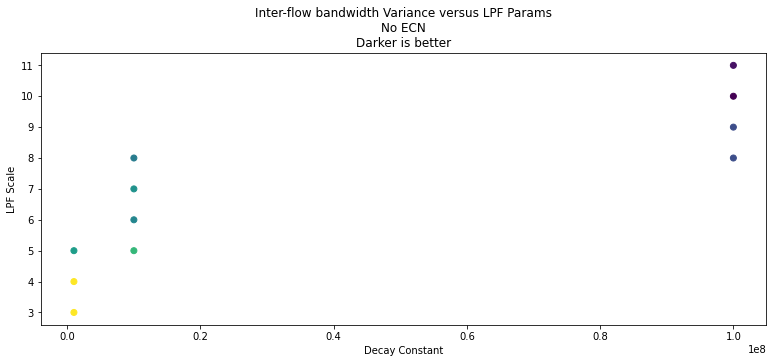

In [2]:
plot_decay_sweep_dir(directories[0], 
                     "Inter-flow bandwidth Variance versus LPF Params\nNo ECN\nDarker is better")

Processing thresh_2048_delta_1024_decay_1e8_scale_11.json
Processing thresh_2048_delta_1024_decay_1e8_scale_10.json
Processing thresh_2048_delta_1024_decay_1e7_scale_05.json
Processing thresh_2048_delta_1024_decay_1e7_scale_08.json
Processing thresh_2048_delta_1024_decay_1e6_scale_04.json
Processing thresh_2048_delta_1024_decay_1e7_scale_07.json
Processing thresh_2048_delta_1024_decay_1e7_scale_06.json
Processing thresh_2048_delta_1024_decay_1e6_scale_05.json
Processing thresh_2048_delta_1024_decay_1e8_scale_09.json
Processing thresh_2048_delta_1024_decay_1e8_scale_08.json
Processing thresh_2048_delta_1024_decay_1e6_scale_03.json
[100000000, 100000000, 10000000, 10000000, 1000000, 10000000, 10000000, 1000000, 100000000, 100000000, 1000000]
[11, 10, 5, 8, 4, 7, 6, 5, 9, 8, 3]
[0.1020111388814546, 0.1018068558071149, 0.2762492841351438, 0.3201743754984616, 0.8313417357980722, 0.3604109999161156, 0.31790470634659207, 0.5501264340422174, 0.09289551246374164, 0.11323454924164082, 0.34140523

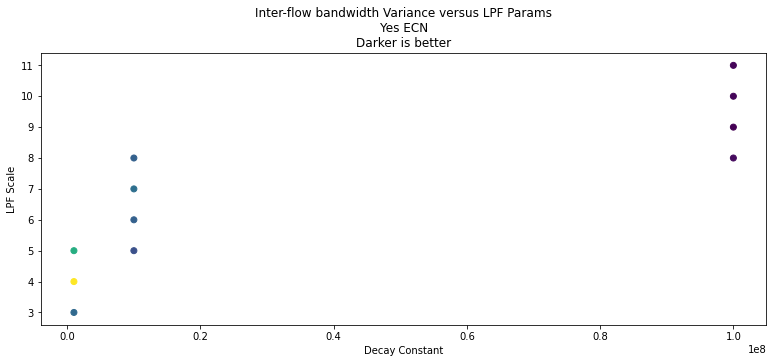

In [3]:
plot_decay_sweep_dir(directories[2], 
                     "Inter-flow bandwidth Variance versus LPF Params\nYes ECN\nDarker is better")

Processing thresh_32768_delta_0.25_decay_1e8_scale_07.json
Processing thresh_0512_delta_0.25_decay_1e8_scale_07.json
Processing thresh_1024_delta_0.25_decay_1e8_scale_07.json
Processing thresh_2048_delta_0.25_decay_1e8_scale_07.json
Processing thresh_16384_delta_0.25_decay_1e8_scale_07.json
Processing thresh_4096_delta_0.25_decay_1e8_scale_07.json
Processing thresh_8192_delta_0.25_decay_1e8_scale_07.json


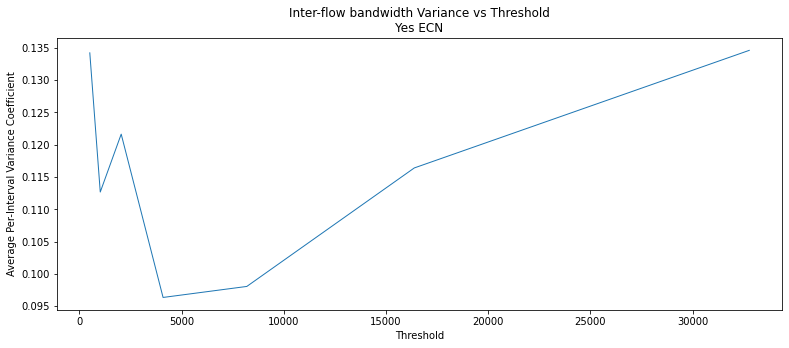

In [4]:
plot_directory(directories[3], 
               lambda x: x[0],
               "Inter-flow bandwidth Variance vs Threshold\nYes ECN",
               "Threshold")

Processing thresh_8192_delta_8192_decay_1e8_scale_07.json
Processing thresh_8192_delta_0512_decay_1e8_scale_07.json
Processing thresh_8192_delta_0256_decay_1e8_scale_07.json
Processing thresh_8192_delta_0064_decay_1e8_scale_07.json
Processing thresh_8192_delta_1024_decay_1e8_scale_07.json
Processing thresh_8192_delta_2048_decay_1e8_scale_07.json
Processing thresh_8192_delta_0128_decay_1e8_scale_07.json
Processing thresh_8192_delta_4096_decay_1e8_scale_07.json


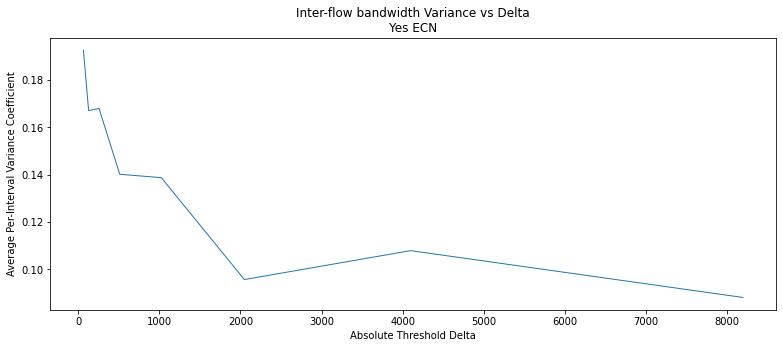

In [5]:
plot_directory(directories[4], 
               lambda x: x[1],
               "Inter-flow bandwidth Variance vs Delta\nYes ECN",
               "Absolute Threshold Delta")

Processing thresh_2048_delta_0064_decay_1e7_scale_08.json
Processing thresh_1024_delta_0064_decay_1e7_scale_08.json
Processing thresh_4096_delta_0064_decay_1e7_scale_08.json
Processing thresh_8192_delta_0064_decay_1e7_scale_08.json
Processing thresh_0512_delta_0064_decay_1e7_scale_08.json


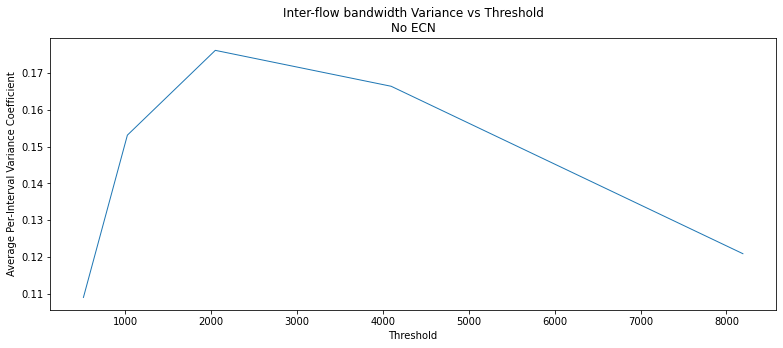

In [6]:
plot_directory(directories[1], 
               lambda x: x[0],
               "Inter-flow bandwidth Variance vs Threshold\nNo ECN",
               "Threshold")

In [7]:
a = [(1,5), (2,4), (3,3)]
a.sort(key=lambda x:x[1])
a

[(3, 3), (2, 4), (1, 5)]

In [8]:
import os
print(os.getcwd())

/Users/macdavid/Code/approx-upf/notebook


In [9]:
import numpy as np

In [10]:
np.mean([1,2,3,4,5])

3.0